**1. Import the necessary libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import keras

from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

import os
import cv2
from tqdm import tqdm

import time

from os import listdir
import csv

Working on dataset paths

In [2]:
!ls ../input/planets-dataset/planet/planet

sample_submission.csv  test-jpg  train-jpg  train_classes.csv


In [3]:
import gc
gc.collect()

46

In [4]:
data_path = '../input/planets-dataset/planet/planet'
train_path = os.path.join(data_path, "train-jpg")
test_path = os.path.join(data_path, "test-jpg")
train_class_path = os.path.join(data_path, "train_classes.csv")
submission_path = os.path.join(data_path, "sample_submission.csv")

In [5]:
df = pd.read_csv(train_class_path)

In [6]:
sub_df = pd.read_csv(submission_path)

In [7]:
df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [8]:
sub_df

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water
...,...,...
61186,file_9995,primary clear agriculture road water
61187,file_9996,primary clear agriculture road water
61188,file_9997,primary clear agriculture road water
61189,file_9998,primary clear agriculture road water


In [9]:
df.shape

(40479, 2)

In [10]:
sub_df.shape

(61191, 2)

In [11]:
df.sample(5)

,image_name,tags
28098,train_28098,clear primary
17019,train_17019,partly_cloudy primary
7184,train_7184,clear habitation primary road water
28699,train_28699,haze primary
37748,train_37748,agriculture haze primary


**2. Data Processing**

In [12]:
df['tags']

0                                         haze primary
1                      agriculture clear primary water
2                                        clear primary
3                                        clear primary
4            agriculture clear habitation primary road
                             ...                      
40474                                    clear primary
40475                                           cloudy
40476                        agriculture clear primary
40477                   agriculture clear primary road
40478    agriculture cultivation partly_cloudy primary
Name: tags, Length: 40479, dtype: object

In [13]:
# create dictionary of labels and their corresponding counts in the dataframe
counts = {}
split_tags = df['tags'].map(lambda x: x.split(' '))

In [14]:
split_tags

0                                          [haze, primary]
1                     [agriculture, clear, primary, water]
2                                         [clear, primary]
3                                         [clear, primary]
4          [agriculture, clear, habitation, primary, road]
                               ...                        
40474                                     [clear, primary]
40475                                             [cloudy]
40476                        [agriculture, clear, primary]
40477                  [agriculture, clear, primary, road]
40478    [agriculture, cultivation, partly_cloudy, prim...
Name: tags, Length: 40479, dtype: object

In [15]:
gc.collect()

46

In [16]:
split_tags.shape

(40479,)

In [17]:
split_tags.values

array([list(['haze', 'primary']),
       list(['agriculture', 'clear', 'primary', 'water']),
       list(['clear', 'primary']), ...,
       list(['agriculture', 'clear', 'primary']),
       list(['agriculture', 'clear', 'primary', 'road']),
       list(['agriculture', 'cultivation', 'partly_cloudy', 'primary'])],
      dtype=object)

In [18]:
for labels in split_tags.values:
    for label in labels:
        if label in counts:
            counts[label] += 1
        else:
            counts[label] =0

In [19]:
counts

{'haze': 2696,
 'primary': 37512,
 'agriculture': 12314,
 'clear': 28430,
 'water': 7410,
 'habitation': 3659,
 'road': 8070,
 'cultivation': 4546,
 'slash_burn': 208,
 'cloudy': 2088,
 'partly_cloudy': 7260,
 'conventional_mine': 99,
 'bare_ground': 861,
 'artisinal_mine': 338,
 'blooming': 331,
 'selective_logging': 339,
 'blow_down': 100}

In [20]:
len(counts)

17

In [21]:
# defining range of X
range_x = range(len(counts.values()))

In [22]:
range_x

range(0, 17)

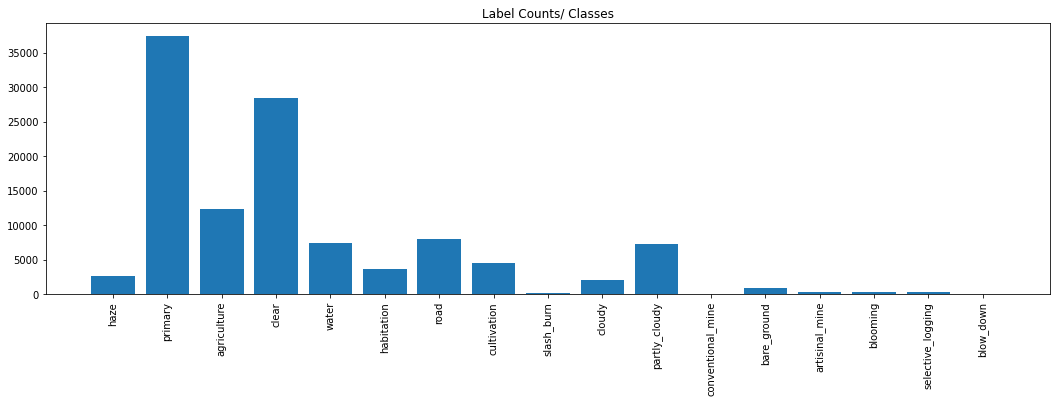

In [23]:
# plotting the label counts i.e. classes
plt.figure(figsize = (18, 5))
plt.title('Label Counts/ Classes')
plt.xticks(range_x, counts.keys(), rotation = 90)
plt.bar(range_x, counts.values())
plt.show()

In [24]:
import gc
gc.collect()

4680

**3. Load and Split the dataset**

In [25]:
labels = split_tags.values
lab = list(set([y for x in labels for y in x]))

def load_dataset(df, lab, resize):
    X_samp = []
    y_samp = []
    
    label_map = {l: i for i, l in enumerate(lab)}
    invert_label_map = {i: l for l, i in label_map.items()}
    
    for file, tag in df.values:
        image = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(file))
        targets = np.zeros(17)
        for tar in tag.split(' '):
            targets[label_map[tar]] = 1
            
        X_samp.append(cv2.resize(image, resize))
        y_samp.append(targets)
        
    y_samp = np.array(y_samp, np.uint8)
    X_samp = np.array(X_samp, np.float16)/ 255
    
    return X_samp, y_samp

In [26]:
X, y = load_dataset(df, lab, resize=(128, 128))

In [27]:
import gc
gc.collect()

435

In [28]:
X

array([[[[0.4038, 0.4392, 0.3726],
         [0.4038, 0.443 , 0.3765],
         [0.4236, 0.4548, 0.4038],
         ...,
         [0.396 , 0.4158, 0.341 ],
         [0.408 , 0.4353, 0.3726],
         [0.408 , 0.4314, 0.3765]],

        [[0.396 , 0.4197, 0.357 ],
         [0.4   , 0.4275, 0.3647],
         [0.4236, 0.447 , 0.392 ],
         ...,
         [0.4   , 0.4158, 0.353 ],
         [0.4   , 0.4197, 0.3608],
         [0.4038, 0.4236, 0.3608]],

        [[0.4119, 0.4275, 0.3687],
         [0.408 , 0.4275, 0.3687],
         [0.408 , 0.4392, 0.3765],
         ...,
         [0.4119, 0.4392, 0.3647],
         [0.4   , 0.4236, 0.349 ],
         [0.392 , 0.4236, 0.3452]],

        ...,

        [[0.4158, 0.443 , 0.3726],
         [0.4158, 0.447 , 0.3804],
         [0.4158, 0.443 , 0.3765],
         ...,
         [0.4038, 0.4158, 0.3333],
         [0.408 , 0.4197, 0.341 ],
         [0.396 , 0.4038, 0.3293]],

        [[0.4236, 0.4392, 0.3687],
         [0.4236, 0.443 , 0.3765],
         [0.

In [29]:
X.shape

(40479, 128, 128, 3)

In [30]:
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [31]:
y.shape

(40479, 17)

In [32]:
time.time()

1673873150.1938293

In [33]:
gc.collect()

115

train, validation set split

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = int(time.time()))

In [35]:
X_train

array([[[[0.149  , 0.1765 , 0.1255 ],
         [0.1686 , 0.1765 , 0.149  ],
         [0.1804 , 0.2    , 0.1608 ],
         ...,
         [0.1333 , 0.1372 , 0.0863 ],
         [0.1294 , 0.1451 , 0.1098 ],
         [0.153  , 0.1765 , 0.1333 ]],

        [[0.196  , 0.2354 , 0.196  ],
         [0.2079 , 0.2313 , 0.2196 ],
         [0.1765 , 0.2    , 0.1765 ],
         ...,
         [0.153  , 0.1647 , 0.1098 ],
         [0.149  , 0.1726 , 0.1216 ],
         [0.1412 , 0.1647 , 0.1098 ]],

        [[0.1804 , 0.2118 , 0.1569 ],
         [0.2157 , 0.2432 , 0.196  ],
         [0.2    , 0.2354 , 0.1882 ],
         ...,
         [0.1921 , 0.2079 , 0.1804 ],
         [0.1882 , 0.2118 , 0.1686 ],
         [0.153  , 0.1686 , 0.1137 ]],

        ...,

        [[0.2079 , 0.2313 , 0.1882 ],
         [0.1686 , 0.204  , 0.1686 ],
         [0.1765 , 0.2118 , 0.1765 ],
         ...,
         [0.1255 , 0.1372 , 0.08234],
         [0.1882 , 0.2157 , 0.1882 ],
         [0.196  , 0.2196 , 0.1882 ]],

        [[

In [36]:
X_train.shape

(32383, 128, 128, 3)

In [37]:
X_val

array([[[[0.298 , 0.3333, 0.2942],
         [0.3098, 0.3293, 0.2864],
         [0.3098, 0.3293, 0.2825],
         ...,
         [0.2744, 0.2627, 0.1686],
         [0.2588, 0.2744, 0.1804],
         [0.255 , 0.2825, 0.196 ]],

        [[0.2864, 0.3137, 0.2666],
         [0.2864, 0.3098, 0.2588],
         [0.298 , 0.3176, 0.2666],
         ...,
         [0.2588, 0.255 , 0.1765],
         [0.251 , 0.2666, 0.1804],
         [0.2666, 0.2783, 0.204 ]],

        [[0.2783, 0.2942, 0.2432],
         [0.2825, 0.302 , 0.2471],
         [0.2903, 0.3176, 0.2627],
         ...,
         [0.2471, 0.251 , 0.1726],
         [0.251 , 0.255 , 0.1765],
         [0.2705, 0.2744, 0.2079]],

        ...,

        [[0.2744, 0.2903, 0.2313],
         [0.2705, 0.306 , 0.2471],
         [0.2705, 0.298 , 0.2393],
         ...,
         [0.2744, 0.2705, 0.2118],
         [0.2864, 0.2942, 0.2313],
         [0.2588, 0.2705, 0.196 ]],

        [[0.2666, 0.2903, 0.2235],
         [0.2666, 0.306 , 0.2393],
         [0.

In [38]:
y_train.shape

(32383, 17)

In [39]:
y_val.shape

(8096, 17)

In [40]:
y.shape[0] == np.sum(y_train.shape[0] + y_val.shape[0])

True

In [41]:
X.shape[0] == np.sum((X_train.shape[0] + X_val.shape[0]))

True

One-Hot encoding the features

In [42]:
# Function for plotting learning curve
def lr_curve(fitted_model, key = "acc", ylimits = (0.8, 1.01)):
    plt.figure(figsize=(12, 6))
    plt.plot(fitted_model.history[key])
    plt.plot(fitted_model.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc = 'best')
    plt.show()

In [43]:
# Function to calculate F-Beta Score
def calc_fbeta_score(y_orig, y_pred, beta = 2, epsilon = 1e-4):
    beta_squared = beta**2
    
    true_pos = K.sum(y_orig * y_pred) + K.epsilon()
    false_pos = K.sum(y_pred) - true_pos
    false_neg = K.sum(y_orig) - true_pos
    
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    
    res = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return res

In [44]:
def accuracy_score(y_orig, y_pred, epsilon = 1e-4):
    true_pos = K.sum(y_orig * y_pred) + K.epsilon()
    false_pos = K.sum(y_pred) - true_pos
    false_neg = K.sum(y_orig) - true_pos
    
    acc = (true_pos + true_neg)/(true_pos + true_neg + false_pos + false_neg +epsilon)
    return acc

In [45]:
gc.collect()

184

**4. Model Building**

In [46]:
# CNN for Image Classification
# The Baseline model with relu activation function

def build_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Flatten(),

        Dense(1024, activation='relu'),
        Dense(17, activation='sigmoid') 
    ])

    return model

In [47]:
gc.collect()

23

In [48]:
model = build_model()
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [calc_fbeta_score, accuracy_score])
model.summary()

2023-01-16 12:46:19.353830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 12:46:19.443355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 12:46:19.444131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 12:46:19.447765: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [49]:
model

In [50]:
gc.collect()

46

In [ ]:
model_fit = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(X_val, y_val)
)

In [ ]:
y_pred = model.predict(X_val, batch_size = 128)
score = fbeta_score(y_val, np.array(y_pred)>0.2, beta=2, average='samples')

print("F beta score: ", score)
print("Error: %.2f%%" %(100-(score*100)))

In [ ]:
lr_curve(model_fit, key = 'loss', ylim = (0, 1))

**5. Optimization**

In [ ]:
"""
5.1 Import VGG16 pre-trained model
5.2 Flatten the input
5.3 Dense layers to predict the output
"""

In [ ]:
optimizer = Adam(0.003, decay = 0.0005)
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (128, 128, 3))

# acquinting the model with custom features
for layer in base_model.layers:
    layer.trainable = False
    
    model = Sequential([
        base_model,
        
        Flatten(), 
        
        Dense(128, activation = 'relu'), 
        Dropout(0.2),
        Dense(17, activation = 'sigmoid')
    ])
    
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = [calc_fbeta_score, accuracy_score])
model.summary()

In [ ]:
model_fit1 = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(X_val, y_val)
)

In [ ]:
y_pred1 = model.predict(X_val, batch_size = 128)
score1 = calc_fbeta_score(y_val, np.array(y_pred1) > 0.2, beta = 2, average = 'samples')

print("F beta score: ", score1)
print("Error: %.2f%%" %(100-(score1*100)))

In [ ]:
lr_curve(model_fit1, key = 'loss', ylim = (0, 1))